### **T5**

T5 is a Transformer-based language model (Encoder-decoder architecture) trained on multiple tasks including summarization, sentiment-analysis, q&a, translation etc.

This implementation takes as inputs a prompt which begins by the task at hand here. Examples of some tasks include summarize: <PROMPT>, translate English to French: <PROMPT>, etc.

1. ONNX T5-encoder: Outputs a Sequence of hidden-states at the last layer of the model. It's a float tensor of size (batch_size, sequence_length, hidden_size).
2. ONNX T5-decoder-with-lm-head: Prediction scores of the language modeling head. It's a float tensor of size (batch_size, sequence_length, vocab_size). The decoder is run in a for-loop and takes output of the previous iteration as input of the current iteration. The other input to the decoder is the hidden-state(output of the encoder).

In the current setup, we perform fault injection in the encoder and decoder separately. 


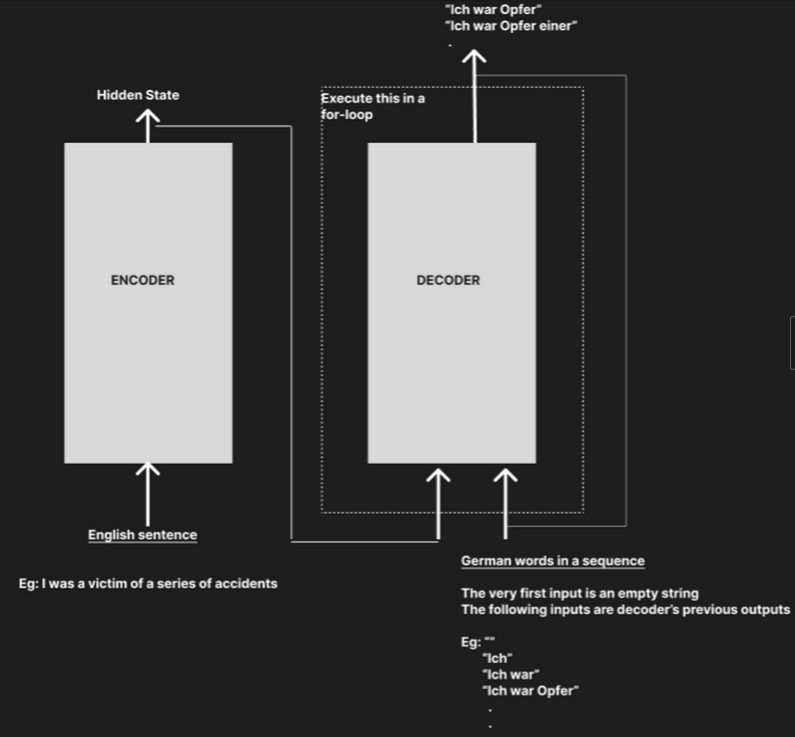

In [ ]:
# Required installation
!pip install transformers
!pip install onnx
!pip install onnxruntime
!pip install onnxruntime_extensions
!pip install onnxt5

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import trange
from transformers import T5Tokenizer
from onnxruntime import InferenceSession
from onnxt5.api import get_encoder_decoder_tokenizer
import onnxt5
from onnxt5 import GenerativeT5
import numpy as np
from onnx import numpy_helper
import glob
import os
import json

In [ ]:
!wget https://github.com/onnx/models/raw/main/text/machine_comprehension/t5/model/t5-decoder-with-lm-head-12.onnx
!wget https://github.com/onnx/models/raw/main/text/machine_comprehension/t5/model/t5-encoder-12.onnx

In [ ]:
# Ref: https://github.com/abelriboulot/onnxt5
### Helper class to run both encoder and decoder and generate output text
class GenerativeT5_pytorch(torch.nn.Module):
    """ This wrapper utility function implements a single beam search to generate efficiently text.
        A lot of the credit goes to the huggingface team and its chief scientist Thomas Wolf whose implementation I based
        myself off.
        Args:
            encoder: huggingface encoder or onnx session for the encoder of T5. Can be obtained with the
                create_t5_encoder_decoder utility function for pytorch, see examples below.
            decoder_with_lm_head: decoder with language model head on top. Can be obtained with the
                create_t5_encoder_decoder utility function for pytorch, see examples below.
            tokenizer: huggingface tokenizer
            onnx (bool): whether to use onnx or the default pytorch
            cuda (bool): whether to use cuda or the cpu
        Examples:
            For pytorch:
            >>> from transformers import T5Tokenizer
            >>> from onnxt5 import create_t5_encoder_decoder, GenerativeT5
            >>> pretrained_model = 't5-base' # This can be a pretrained version, or the path to a huggingface model
            >>> simplified_encoder, decoder_with_lm_head = create_t5_encoder_decoder(pretrained_model)
            >>> tokenizer = T5Tokenizer.from_pretrained(pretrained_model)
            >>> generative_t5 = GenerativeT5(simplified_encoder, decoder_with_lm_head, tokenizer)
            >>> generative_t5('translate English to French: I was a victim of a series of accidents.', 16, temperature=0.)[0]
            >>> # Output: "Je suis victime d'une série d'accidents."
            For onnx:
            >>> from transformers import T5Tokenizer
            >>> from onnxruntime import InferenceSession
            >>> from onnxt5 import GenerativeT5
            >>> decoder_sess = InferenceSession('~/t5-decoder-with-lm-head.onnx')
            >>> encoder_sess = InferenceSession('~/t5-encoder.onnx')
            >>> tokenizer = T5Tokenizer.from_pretrained(pretrained_model)
            >>> generative_t5 = GenerativeT5(encoder_sess, decoder_sess, tokenizer, onnx=True)
            >>> generative_t5('translate English to French: I was a victim of a series of accidents.', 16, temperature=0.)[0]
            >>> # Output: "Je suis victime d'une série d'accidents."
    """
    def __init__(self, encoder, decoder_with_lm_head, tokenizer, onnx=False, cuda=False):
        super().__init__()
        self.encoder = encoder
        self.decoder_with_lm_head = decoder_with_lm_head
        self.tokenizer = tokenizer
        self.onnx = onnx
        self.cuda = cuda

    def forward(self, prompt, max_length, temperature=1., repetition_penalty=1., top_k=50, top_p=0, max_context_length=512):
        """ Forward function to generate text after a prompt
            Args:
                prompt: str to run (don't forget to add at the beginning the task to run such as "summarize:"
                        or "translate English to German:"
                max_context_length: maximum number of tokens to use as context
        """
        with torch.no_grad():
            new_tokens = torch.tensor(())
            new_logits = []
            generated = torch.tensor(self.tokenizer(prompt)['input_ids'])[:max_context_length - 1].unsqueeze(0)
            if self.cuda and not self.onnx:
                generated = generated.cuda()
            temperature = temperature
            # Getting encoder past
            if self.onnx:
                encoder_outputs_prompt = self.encoder.run(None, {"input_ids": generated.cpu().numpy()})[0]
            else:
                encoder_outputs_prompt = self.encoder(generated)
            print(encoder_outputs_prompt.shape)
            repetition_penalty = repetition_penalty
            top_k = top_k
            top_p = top_p

            # The sequence now needs to start with a
            generated = torch.zeros((1,1), dtype=torch.long)
            if self.cuda and not self.onnx:
                generated = generated.cuda()

            for _ in trange(max_length):
                if self.onnx:
                    outputs = torch.tensor(self.decoder_with_lm_head.run(None, {"input_ids": generated.cpu().numpy(),
                                                   "encoder_hidden_states": encoder_outputs_prompt})[0][0])
                else:
                    outputs = self.decoder_with_lm_head(input_ids=generated,
                                                        encoder_hidden_states=encoder_outputs_prompt)[0]
                print(generated)
                next_token_logits = outputs[-1, :] / (temperature if temperature > 0 else 1.0)
                if int(next_token_logits.argmax()) == 1:
                    break
                new_logits.append(next_token_logits)
                for _ in set(generated.view(-1).tolist()):
                    next_token_logits[_] /= repetition_penalty
                if temperature == 0:  # greedy sampling:
                    next_token = torch.argmax(next_token_logits).unsqueeze(0)
                else:
                    filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
                new_tokens = torch.cat((new_tokens, next_token), 0)
                print(self.tokenizer.decode(new_tokens))

            return self.tokenizer.decode(new_tokens), new_logits

In [ ]:
# Use encoder and decoder to generate output text
decoder_sess = InferenceSession('t5-decoder-with-lm-head-12.onnx')
encoder_sess = InferenceSession('t5-encoder-12.onnx')
_, _, tokenizer = get_encoder_decoder_tokenizer()
generative_t5 = GenerativeT5_pytorch(encoder_sess, decoder_sess, tokenizer, onnx=True)
generative_t5('translate English to German: I was a victim of a series of accidents', 16, temperature=0.)[0]

Input: translate English to German: I was a victim of a series of accidents\
Output: Ich war Opfer einer Reihe von Unfällen


In [ ]:
# Test Fault injection with only encoder

# Generate input.pb files with the below prompts
prompts = []
encoder_input = []
prompts.append('translate English to German: I was a victim of accidents')
prompts.append('translate English to French: Today is a bright, sunny day')
prompts.append('translate English to German: Vancouver is a beautiful city')
prompts.append('translate English to French: She sings beautifully')
prompts.append('translate English to German: The cake is very tasty')
max_context_length = 512
_, _, tokenizer = get_encoder_decoder_tokenizer()
# Tokenize the prompts
for prompt in prompts:
  encoder_input.append(torch.tensor(tokenizer(prompt)['input_ids'])[:max_context_length - 1].unsqueeze(0))


In [ ]:
# Convert the tokens to inputs.pb
for index in range(len(encoder_input)):
  tensor = numpy_helper.from_array(encoder_input[index].cpu().numpy())
  with open("input_{}.pb".format(index), 'wb') as file:
      file.write(tensor.SerializeToString())

In [ ]:
# Convert lltfi output to text
ROOT = os.getcwd()
LLFI_OUT = os.path.join(ROOT, 'llfi')
PROG_OUT = os.path.join(LLFI_OUT, 'prog_output')
    
listResArr = []
list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(PROG_OUT, x)),
                            os.listdir(PROG_OUT) ) )

for i in range(len(list_of_files)):
        list_of_files[i] = os.path.join(PROG_OUT, list_of_files[i])

print(list_of_files)
for filename in list_of_files:
  resforSingleInput = []
  with open(filename, "r") as read_file:
    resultJson = json.load(read_file)

  for key, value in resultJson.items():
      resforSingleInput.append(value['Data'])
  listResArr.append(resforSingleInput)
                    
list_output_np = []
    # Reshape the output and store as numpy array
for elem in listResArr:
        output_np = np.asarray(elem[0], dtype=np.float32)
        output_np = output_np.reshape(1,-1,768)
        list_output_np.append(output_np) 

['/content/llfi/prog_output/layeroutput.txt', '/content/llfi/prog_output/layeroutput_1.txt', '/content/llfi/prog_output/layeroutput_2.txt', '/content/llfi/prog_output/layeroutput_3.txt', '/content/llfi/prog_output/layeroutput_4.txt']


In [ ]:
# Get text from LLTFI outputs
class GenerativeT5_custom_encoder(torch.nn.Module):
    """ This wrapper utility function implements a single beam search to generate efficiently text.
        A lot of the credit goes to the huggingface team and its chief scientist Thomas Wolf whose implementation I based
        myself off.
        Args:
            encoder: huggingface encoder or onnx session for the encoder of T5. Can be obtained with the
                create_t5_encoder_decoder utility function for pytorch, see examples below.
            decoder_with_lm_head: decoder with language model head on top. Can be obtained with the
                create_t5_encoder_decoder utility function for pytorch, see examples below.
            tokenizer: huggingface tokenizer
            onnx (bool): whether to use onnx or the default pytorch
            cuda (bool): whether to use cuda or the cpu
        Examples:
            For pytorch:
            >>> from transformers import T5Tokenizer
            >>> from onnxt5 import create_t5_encoder_decoder, GenerativeT5
            >>> pretrained_model = 't5-base' # This can be a pretrained version, or the path to a huggingface model
            >>> simplified_encoder, decoder_with_lm_head = create_t5_encoder_decoder(pretrained_model)
            >>> tokenizer = T5Tokenizer.from_pretrained(pretrained_model)
            >>> generative_t5 = GenerativeT5(simplified_encoder, decoder_with_lm_head, tokenizer)
            >>> generative_t5('translate English to French: I was a victim of a series of accidents.', 16, temperature=0.)[0]
            >>> # Output: "Je suis victime d'une série d'accidents."
            For onnx:
            >>> from transformers import T5Tokenizer
            >>> from onnxruntime import InferenceSession
            >>> from onnxt5 import GenerativeT5
            >>> decoder_sess = InferenceSession('~/t5-decoder-with-lm-head.onnx')
            >>> encoder_sess = InferenceSession('~/t5-encoder.onnx')
            >>> tokenizer = T5Tokenizer.from_pretrained(pretrained_model)
            >>> generative_t5 = GenerativeT5(encoder_sess, decoder_sess, tokenizer, onnx=True)
            >>> generative_t5('translate English to French: I was a victim of a series of accidents.', 16, temperature=0.)[0]
            >>> # Output: "Je suis victime d'une série d'accidents."
    """
    def __init__(self, encoder_outputs_prompt, decoder_with_lm_head, tokenizer, onnx=False, cuda=False):
        super().__init__()
        self.encoder_outputs_prompt = encoder_outputs_prompt
        self.decoder_with_lm_head = decoder_with_lm_head
        self.tokenizer = tokenizer
        self.onnx = onnx
        self.cuda = cuda

    def forward(self, max_length, temperature=1., repetition_penalty=1., top_k=50, top_p=0, max_context_length=512):
        """ Forward function to generate text after a prompt
            Args:
                prompt: str to run (don't forget to add at the beginning the task to run such as "summarize:"
                        or "translate English to German:"
                max_context_length: maximum number of tokens to use as context
        """
        with torch.no_grad():
            new_tokens = torch.tensor(())
            new_logits = []

            repetition_penalty = repetition_penalty
            top_k = top_k
            top_p = top_p

            # The sequence now needs to start with a
            generated = torch.zeros((1,1), dtype=torch.long)
            if self.cuda and not self.onnx:
                generated = generated.cuda()


            for _ in range(max_length):
                outputs = torch.tensor(self.decoder_with_lm_head.run(None, {"input_ids": generated.cpu().numpy(),
                                                   "encoder_hidden_states": self.encoder_outputs_prompt}))
                outputs = outputs[0][0]
                #print(outputs.shape)
                next_token_logits = outputs[-1, :] / (temperature if temperature > 0 else 1.0)
                if int(next_token_logits.argmax()) == 1:
                    break
                new_logits.append(next_token_logits)
                for _ in set(generated.view(-1).tolist()):
                    next_token_logits[_] /= repetition_penalty
                if temperature == 0:  # greedy sampling:
                    next_token = torch.argmax(next_token_logits).unsqueeze(0)
                else:
                    filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
                new_tokens = torch.cat((new_tokens, next_token), 0)

            return self.tokenizer.decode(new_tokens), new_logits

In [ ]:
decoder_sess = InferenceSession('t5-decoder-with-lm-head-12.onnx')
_, _, tokenizer = get_encoder_decoder_tokenizer()
for output_np in list_output_np:
  generative_t5 = GenerativeT5_custom_encoder(output_np, decoder_sess, tokenizer, onnx=True)
  print(generative_t5(30, temperature=0.)[0])